## 2020년 11월 30일  ver.

# table of contents
[1. 필요한 파일 불러오기 및 정리](#bullet1)<br>
[2. 데이터 EDA](#bullet2)<br>
[3. Prediction With Surprise](#bullet3)<br>

# 1. 필요한 파일 불러오기 및 정리<a class="anchor" id="bullet1"></a>


In [1]:
from scipy.stats import pearsonr
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [12]:
all_review = pd.read_csv('data/댓글합.csv',index_col = 0)
all_review.drop_duplicates(inplace=True)
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre
14667,자라32,90,[EBS 세계문학전집] 장발장,정형석,빅토르 위고,잼나예요\r\n잘 들었어요,2020.02.21,한국교육방송공사,어린이동화


In [13]:
all_book = pd.read_csv('data/전체합.csv', index_col = 0)
all_book.sample()

,title,voice,author,publish,genre
983,언어의 온도,박모건,이기주,말글터,인문교양


## 1.1 title_df, user_df 만들기<a class="anchor" id="bullet1.1"></a>

In [13]:
# user_df = pd.DataFrame(list(df.nickname	.unique()), columns = ['nickname'])
# user_df['usr_id'] = random.sample(range(1,len(user_df)+1), len(user_df))

# title_df = pd.DataFrame(list(df.title.unique()), columns = ['title'])
# title_df['ttl_id'] = random.sample(range(1,len(title_df)+1), len(title_df))

# df = df.merge(user_df, how = 'left' )
# df = df.merge(title_df, how = 'left' )
# df.columns = ['user', 'title', 'rating', 'usr_id', 'ttl_id']
# df.sample()

In [14]:
# pivot_df = df.pivot_table('rating', index = 'user', columns = 'title')
# pivot_df.sample(4)

# 2. 데이터 EDA<a class="anchor" id="bullet2"></a>

- **장르의 평점 많은 순 정렬, (평점 개수와 함께) 평점 높은 순 정렬 [@최미리](https://4-rdb2294.slack.com/team/U01841JSBPD)**
- **팟빵 오디오북 유저들의 장르 취향 파악: 한 우물형 vs 포도송이형 @김현진**
- **별점의 분포가 넓은 유저들의 특징과 리뷰를 많이 작성하는 유저들의 별점 분포 [@김연주](https://4-rdb2294.slack.com/team/U0188K64VQV)**
- **기간에 따른 리뷰 댓글 수 차이 비교 (시계열 분석) @박지현**
- **책 내용을 녹음한 목소리의 주인이 누구인지에 따라 평점 수, 평균 비교 [@김한나](https://4-rdb2294.slack.com/team/U017X3BRY0N)**

### 유명인이 읽어주는 경우 vs 작가가 읽어주는 경우 vs 일반성우

**null값을 찾자**

In [15]:
print(f"전체 책 수는 : {len(all_book.title.unique())}")

전체 책 수는 : 1719


작가가 없는 책 찾기

In [16]:
all_book[all_book['author'].isnull()].title.unique()

array(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어', '100인의 배우, 우리 문학을 읽다'],
      dtype=object)

**왜 작가가 없을까**<br>
1) 우리나라 삼국지 5권: 저자 - 임동주. 시리즈 1-4권 까지는 임동주로 나와있음. <br>
2) 흐르는 물이 되어: 작가 - 김동식. <br>
1,2번은 오류로 빠진듯. 데이터에 추가해야 함 <br>

3) 100인의 배우, 우리 문학을 읽다: 여러 책을 함께 담은 시리즈이기 때문에 한 명의 작가는 없음 <br>
[100인 책 페이지](http://m.podbbang.com/audiobook/channel?id=1769055)를 들어가보면 목차 안으로 들어가야 각 책의 제목, 목소리, 작가를 알 수 있음 <br>
그런데 이 목차 안의 콘텐츠를 따로 빼서 제공하는 중이기도 함

In [17]:
all_book[all_book['author'].isnull()].title.unique()

array(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어', '100인의 배우, 우리 문학을 읽다'],
      dtype=object)

In [18]:
all_book[all_book['title'].isin(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어'])]

,title,voice,author,publish,genre
171,우리나라 삼국지 5권,NaN,NaN,임동주,소설문학
455,[김동식 단편] 흐르는 물이 되어,이준우,NaN,김동식,소설문학


In [19]:
all_book.iloc[171, 3] = "임동주"
all_book.iloc[455, 3] = "김동식"

In [20]:
all_book[all_book['title'].isin(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어'])]

,title,voice,author,publish,genre
171,우리나라 삼국지 5권,NaN,NaN,임동주,소설문학
455,[김동식 단편] 흐르는 물이 되어,이준우,NaN,김동식,소설문학


목소리가 잘 들어간 걸 볼 수 있다!

다시 3번으로 돌아와서, 100권 시리즈 외에 한 권씩 따로 서비스 하는 중인지 확인해봤음

In [21]:
all_book[all_book['title'].str.contains('원미동')]

,title,voice,author,publish,genre
724,길해연이 읽는 양귀자의 원미동 시인,길해연,양귀자,커뮤니케이션북스,오디오북스


그러면 이 오디오북 시리즈에 대한 리뷰 따로, 특정 책에 대한 리뷰는 따로 해야할 듯

**voice가 없는 책 찾기**

In [22]:
print(f"전체 책 수는 : {len(all_book.title.unique())}")
print(f"voice가 없는 책 수는 : {len(all_book[all_book['voice'].isnull()].title.unique())}")

전체 책 수는 : 1719
voice가 없는 책 수는 : 846


<div class="alert alert-warning">
기계가 녹음한 경우 voice가 없을 수 있는데 과연 그게 다일지는 모르겠음 <br>
어떻게 우리가 확인할 수 있을까? -> 일단 나중에 고민하고 우선은 Nan == 기계음 으로 생각하자
</div>

**voice tag를 구분하자!**

In [23]:
all_book.sample()

,title,voice,author,publish,genre
1253,"저듸, 곰새기",NaN,장수진,아이들은자연이다,어린이동화


In [24]:
titles = all_book.title.unique() #모든 책 제목을 titles 리스트에 담아서 아래와 같이 구분

In [63]:
read_by_none = all_book[all_book['voice'].isnull()].title.unique()
read_by_author = list(all_book.query('voice == author').title.unique())
read_by_celeb = [title for title in titles if ("낭독" in title) or ("읽는" in title) or ("배우" in title)]
read_by_someone = [title for title in titles if title not in read_by_celeb and title not in read_by_author and title not in read_by_none]

In [64]:
all_book['read_by'] = ""

all_book['read_by'] = all_book['title'].apply(lambda x : "celeb" if x in read_by_celeb else ("author" if x in read_by_author else ("someone" if x in read_by_someone else "robot")))

all_book.sample(5)

,title,voice,author,publish,genre,read_by
1224,나 홀로 버스,NaN,남강한,도서출판 북극곰,어린이동화,robot
300,[단편] 삼인행,NaN,권여선,창비,소설문학,robot
69,김약국의 딸들,홍영란,박경리,와미디어,소설문학,someone
840,1등은 당신처럼 공부하지 않았다,NaN,김도윤,쌤앤파커스,자기계발,robot
196,[김도연 낭독] 림 로드 (단편),김도연 (위키미키),배미주,창비,소설문학,celeb


#### 목소리별 평점 

In [67]:
all_book

,title,voice,author,publish,genre,read_by
0,"매향리, 평화가 오다",이미나,"화성시(기획),전혜진(글),김준현(사진)",화성시,소설문학,someone
1,[이유영 낭독] 다정한 유전 _작은책,이유영,강화길,아르테,소설문학,celeb
2,저스트 어 모멘트,이나리,이경화,탐,소설문학,someone
3,사춘기라서 그래,조현정,이명랑,탐,소설문학,someone
4,[단편] 헤엄치는 밤,최인영,한유주,미디어창비,소설문학,someone
...,...,...,...,...,...,...
1718,땍때굴,NaN,김이구,창비,어린이동화,robot
1719,꿈틀꿈틀,NaN,김이구,창비,어린이동화,robot
1720,어린이를 위한 안데르센 영어동화,NaN,한스 크리스티안 안데르센,팟빵북스,어린이동화,robot
1721,7년 동안의 잠,유경선,박완서,어린이작가정신,어린이동화,someone


In [68]:
review_by_voice = all_review.merge(all_book[['title', 'read_by']], how='left').pivot_table(index = "nickname", columns = 'read_by', values = "rating", aggfunc = "mean")
review_by_voice

read_by,author,celeb,robot,someone
nickname,,,,
00young,NaN,NaN,NaN,100.0
015bc603,NaN,100.0,NaN,NaN
027,NaN,NaN,NaN,100.0
091222,NaN,NaN,NaN,90.0
09abc,100.0,NaN,100.0,100.0
...,...,...,...,...
히힛잉,100.0,100.0,100.0,90.0
힉스입자,NaN,NaN,100.0,100.0
힐데,NaN,100.0,NaN,NaN


In [69]:
all_review[all_review['title'].isin(read_by_author)].rating.describe()

count    2007.000000
mean       97.897359
std         8.351896
min        10.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: rating, dtype: float64

In [70]:
all_review[all_review['title'].isin(read_by_celeb)].rating.describe()

count    4273.000000
mean       93.859115
std        12.270965
min        10.000000
25%        90.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: rating, dtype: float64

In [71]:
all_review[all_review['title'].isin(read_by_someone)].rating.describe()

count    6965.000000
mean       94.983489
std        12.113781
min        10.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: rating, dtype: float64

In [72]:
all_review[all_review['title'].isin(read_by_none)].rating.describe()

count    2283.000000
mean       93.758213
std        12.351742
min        10.000000
25%        90.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: rating, dtype: float64

In [73]:
all_review[all_review.author.isnull()].title.unique()

array(['100인의 배우, 우리 문학을 읽다'], dtype=object)

In [74]:
all_review = all_review.merge(all_book[['title', 'read_by']], how='left')

In [75]:
all_review.sample(3)

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
9020,김바위,80,최민식이 읽는 이범선의 오발탄,최민식,이범선,목소리 좋아요,2018.12.31,커뮤니케이션북스,오디오북스,celeb
4117,왓섭소유니,100,[공포괴담집] 무조건 모르는 척하세요,왓섭,문화류씨,드뎌 오디오북 2권 나왔군요 기쁜 마음에 바로 구입 완료했어요 정말 고생 많으셨습니...,2019.06.20,요다,소설문학,someone
685,나요저요,100,살고 싶다는 농담,신경선,허지웅,구독구독,2020.11.01,웅진지식하우스,소설문학,someone


(array([  10.,    6.,    5.,    5.,    9.,   39.,   66.,  279.,  276.,
        1594.]),
 array([ 10.,  19.,  28.,  37.,  46.,  55.,  64.,  73.,  82.,  91., 100.]),
 <BarContainer object of 10 artists>)

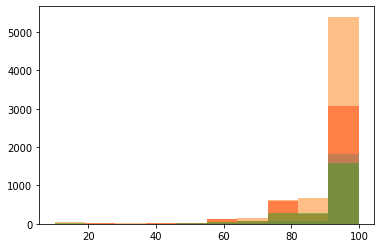

In [285]:
# 따로 그리고 싶다.. 그러나 한 셀 안에..
plt.hist(all_review.query('read_by == "celeb"')['rating'], alpha = 0.5, color = "r")
plt.hist(all_review.query('read_by == "author"')['rating'], alpha = 0.5)
plt.hist(all_review.query('read_by == "someone"')['rating'], alpha = 0.5)
plt.hist(all_review.query('read_by == "robot"')['rating'], alpha = 0.5)

In [83]:
from statsmodels.formula.api import ols

In [84]:
ols('rating ~ read_by', data = all_review).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     55.93
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           5.97e-36
Time:                        15:33:21   Log-Likelihood:                -60349.
No. Observations:               15530   AIC:                         1.207e+05
Df Residuals:                   15526   BIC:                         1.207e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             97.8974      0.263    372.034      0.000      97.382      98.413
read_by[T.celeb]      -3.7277      0.320    -11.635      0.000      -4.356      -3.100
read_by[T.robot]      -4.1391      0.361    -11.475      0.000      -4.846      -3.432
read_by[T.someone]    -3.1198      0.298    -10.465      0.000      -3.704      -2.536
==============================================================================
Omnibus:                    11528.393   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           206586.161
Skew:                          -3.485   Prob(JB):                         0.00
Kurtosis:                      19.452   Cond. No.                         6.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

일반적으로 작가가 읽었을 때 가장 평점이 높음<br>
근데 r제곱이 1퍼센트..^^

In [89]:
all_review['rating'].quantile(np.arange(0.2, 0.4, 0.05))

0.20     90.0
0.25    100.0
0.30    100.0
0.35    100.0
Name: rating, dtype: float64

In [139]:
for_plot.iloc[:18, :]

,percentage,rating_value
0,0.0,10.0
1,0.025,60.0
2,0.05,70.0
3,0.07500000000000001,80.0
4,0.1,80.0
5,0.125,80.0
6,0.15000000000000002,80.0
7,0.17500000000000002,90.0
8,0.2,90.0
9,0.225,90.0


In [149]:
a = 0.03023

In [151]:
round(a,3)

0.03

In [154]:
for_plot = all_review['rating'].quantile(np.arange(0, 1, 0.025)).to_frame().reset_index()

for_plot.columns = ['percentage', 'rating_value']

for_plot['percentage'] = for_plot['percentage'].apply(lambda x : round(x, 3)).apply(str)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

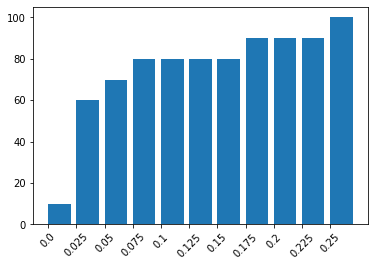

In [155]:
plt.bar(for_plot.iloc[:11, :]['percentage'], for_plot.iloc[:11, :]['rating_value'], align = 'edge')
plt.xticks(rotation = 45)

In [158]:
plt.xticks?

In [168]:
plt.bar?

([], [])

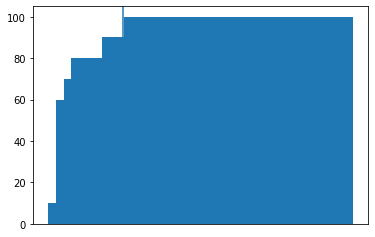

In [170]:
plt.bar(for_plot['percentage'], for_plot['rating_value'], align = 'edge', width = 1)
plt.axvline(x=9.8)
plt.xticks([])

In [173]:
# sns.lmplot을 어떻게 잘 써볼 수 있을까..


In [77]:
review_count_read_by = all_review.pivot_table(index = "rating", columns = "read_by", values = "review", aggfunc = "count")
review_count_read_by

read_by,author,celeb,robot,someone
rating,,,,
10,5.0,3.0,9.0,46.0
20,2.0,11.0,6.0,18.0
30,NaN,1.0,5.0,8.0
40,2.0,13.0,5.0,18.0
50,7.0,8.0,9.0,29.0
60,12.0,118.0,39.0,122.0
70,17.0,83.0,66.0,149.0
80,74.0,594.0,278.0,607.0
90,67.0,259.0,274.0,679.0


In [78]:
review_count_read_by.author.sum()

2003.0

In [79]:
# 확인하기
len(all_review.query('read_by == "author"'))

2007

review로 count하면 review가 없는 경우도 있어서 안됨 <br>
위의 테이블을 잘 확인하려면 with_review 테이블로 해야

In [80]:
with_review = all_review.dropna(how = 'any',subset=["review"], axis = 0) #rating만 있는 경우 drop

In [81]:
with_review["length"] = with_review['review'].apply(len)
with_review.sample()

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,nickname,rating,title,voice,author,review,created,publish,genre,read_by,length
2100,단밭빵퉷,80,담배만이 우리 세상,남도형,류연웅,학창시절 생각나네요 \r\n재밌게 잘들었습니다.,2019.09.29,안전가옥,소설문학,someone,24


In [142]:
with_review[(with_review['review'].str.contains('들었습니다')) & (with_review['length'] < 10)].review.unique()[:3] #세개만 샘플로 뽑아봤어요

array(['잘들었습니다.', '잘들었습니다', '잘 들었습니다'], dtype=object)

## 유저별 평점 variance 

In [184]:
review_per_user = all_review.groupby(['nickname', 'title'])['rating'].first().to_frame().reset_index()
review_per_user.sample()

,nickname,title,rating
2169,hamsik,[EBS 세계문학전집] 15소년 표류기,100


In [241]:
review_count = review_per_user.groupby('nickname')['rating'].count().to_frame()
review_one = list(review_count.query('rating == 1').index)

In [245]:
review_var = review_per_user[~review_per_user['nickname'].isin(review_one)].groupby('nickname')['rating'].var(ddof = 0).to_frame()
review_var.columns = ['rating_variance']
review_var.sample()

,rating_variance
nickname,
반지하빌런,0.0


In [232]:
review_var[review_var['rating_variance'].isnull()].shape[0]

0

In [233]:
review_var.query('nickname == "amartia"')

,rating_variance
nickname,
amartia,25.0


In [214]:
review_per_user.query('nickname == "amartia"')

,nickname,title,rating
954,amartia,모두 거짓말을 한다,80
955,amartia,아몬드,90


In [246]:
review_var.sample(3)

,rating_variance
nickname,
djsjsjss,669.421488
그라닡,0.000000
Sky123000,0.000000


In [249]:
np.var(review_per_user.query("nickname == 'djsjsjss'")['rating'])

669.4214876033056

{'whiskers': [<matplotlib.lines.Line2D at 0x1d08855ad08>,
 'caps': [<matplotlib.lines.Line2D at 0x1d08820f988>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d088454ac8>],
 'medians': [<matplotlib.lines.Line2D at 0x1d088335308>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d08812ecc8>],
 'means': []}

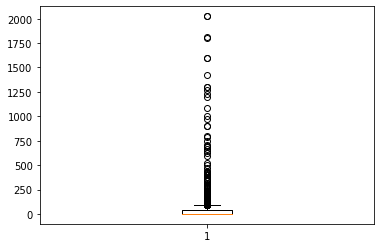

In [255]:
plt.boxplot(review_var)

{'whiskers': [<matplotlib.lines.Line2D at 0x1d08850c288>,
 'caps': [<matplotlib.lines.Line2D at 0x1d088480f88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d08848e208>],
 'medians': [<matplotlib.lines.Line2D at 0x1d08848b988>],
 'fliers': [],
 'means': []}

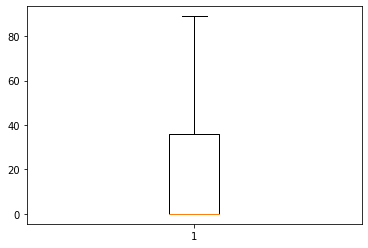

In [254]:
plt.boxplot(review_var, showfliers=False)

In [ ]:
plt.boxplot(review_var, showfliers=False)

(array([1553.,   58.,    9.,    9.,    4.,    2.,    4.,    3.,    2.,
           2.]),
 array([   0. ,  202.5,  405. ,  607.5,  810. , 1012.5, 1215. , 1417.5,
        1620. , 1822.5, 2025. ]),
 <BarContainer object of 10 artists>)

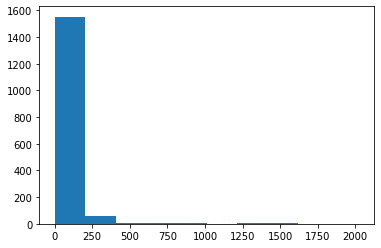

In [258]:
plt.hist(review_var)

In [266]:
review_var_count = review_var.merge(review_count, left_index = True, right_index = True)
review_var_count.columns = ['rating_variance', 'rating_count']
review_var_count.sample()

,rating_variance,rating_count
nickname,,
갯민숭달팽이,625.0,2


In [260]:
review_var.describe()

,rating_variance
count,1646.000000
mean,52.795470
std,165.269261
min,0.000000
25%,0.000000
50%,0.000000
75%,35.984375
max,2025.000000


In [268]:
review_var_count

,rating_variance,rating_count
nickname,,
091222,66.666667,3
09abc,0.000000,5
0오공0,75.000000,16
1025khd,0.000000,8
12최정,75.000000,4
...,...,...
히풋러,55.555556,6
히히덕,0.000000,25
히힛잉,69.135802,9


## general EDA

In [330]:
print(f"리뷰데이터의 크기는             : {all_review.shape}")
print(f"리뷰데이터에 포함된 유저의 수는 : {len(all_review['nickname'].unique())} 명")
print(f"리뷰데이터에 포함된 책의 수는   : {len(all_review['title'].unique())} 권")

리뷰데이터의 크기는             : (15533, 11)
리뷰데이터에 포함된 유저의 수는 : 4450 명
리뷰데이터에 포함된 책의 수는   : 195 권


C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


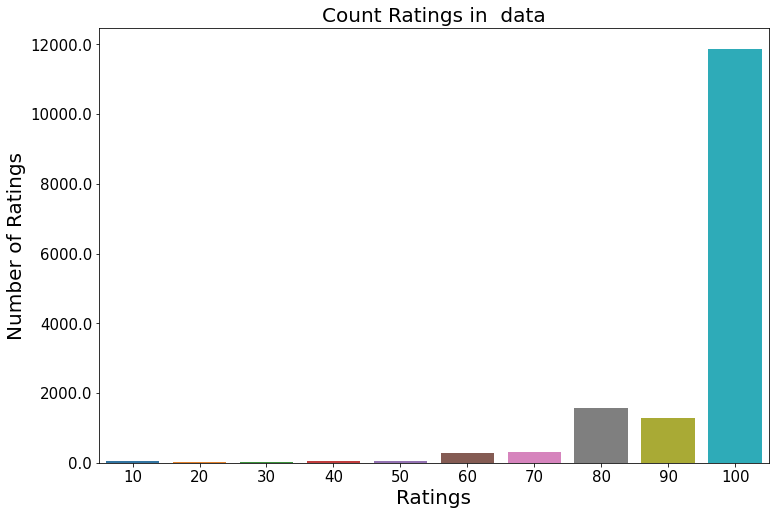

In [143]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=all_review)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings in  data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

일단 가장 높은 n개의 값만 보여주는 함수를 만듭니다.

In [336]:
def return_best_n(statistics, n):
    # statistics: array of size review.shape[1] containing one statistic calculated from the dataset
    # n: number of indices to be returned
    # returns: array of size *n* containing the indices of the best scored statistics
    statistics = pd.DataFrame({'statistic':statistics})
    return statistics.sort_values('statistic', ascending = False).iloc[:n]

### Mean Rating <a class="anchor" id="bullet2.1"></a>


In [337]:
means = all_review.pivot_table(columns='title', index = 'nickname', values = 'rating').iloc[:,2:].apply(np.mean)
return_best_n(means,10)

,statistic
title,
"달려라, 아비",100.0
[와우 낭독] 지금 아니면 못 할 일 (단편),100.0
이원승이 읽는 현진건의 운수 좋은 날,100.0
김의성이 읽는 최인호의 타인의 방,100.0
김용 대하역사무협 신조협려 하이라이트,100.0
김영민이 읽는 현경준의 탁류,100.0
길해연이 읽는 양귀자의 원미동 시인,100.0
기주봉이 읽는 하근찬의 수난이대,100.0
공룡 이야기 마을_고집 센 벨로키랍토르(영어),100.0


### Rating Count<a class="anchor" id="bullet2.2"></a>


In [223]:
count = all_review.pivot_table(columns='title', index = 'nickname', values = 'rating').iloc[:,2:].apply(lambda col : np.sum(~np.isnan(col)))

# return_best_n(count,10).index 를 구하면 제목만 뽑을 수 있음
return_best_n(count,10)

NameError: name 'return_best_n' is not defined

In [222]:
count

NameError: name 'count' is not defined

평균 평점 top10의 책은 몇개의 리뷰가 있을까?

In [339]:
top10_avg_ratings = return_best_n(means,10).index
count.loc[top10_avg_ratings]

title
달려라, 아비                      1
[와우 낭독] 지금 아니면 못 할 일 (단편)    1
이원승이 읽는 현진건의 운수 좋은 날         2
김의성이 읽는 최인호의 타인의 방           5
김용 대하역사무협 신조협려 하이라이트         2
김영민이 읽는 현경준의 탁류              1
길해연이 읽는 양귀자의 원미동 시인          1
기주봉이 읽는 하근찬의 수난이대            1
공룡 이야기 마을_고집 센 벨로키랍토르(영어)    1
강신일이 읽는 최서해의 탈출기             1
dtype: int64

### Percentage of Good Ratings<a class="anchor" id="bullet2.3"></a>


In [340]:
good_count = all_review.pivot_table(columns='title', index = 'nickname', values = 'rating').iloc[:,2:].apply(lambda col : np.sum(col >=  80)/np.sum(~np.isnan(col)))
return_best_n(good_count,3)

,statistic
title,
<테이크아웃 오디오북> 목견,1.0
눈물을 자르는 눈꺼풀처럼(시 10편),1.0
신경 끄기의 기술 (완독),1.0


In [13]:
#위 코드 이해하기
col = pivot_df.iloc[:,2:]['나는 왠지 대박날 것만 같아!']
print(np.sum(col >= 80))
print(np.sum(~np.isnan(col)))

387
391


애초에 리뷰가 한개인 경우는 리뷰 수 대비 좋은 리뷰 값이 1로 나옴<br>
이걸 해결하기 위해서 리뷰 숫자가 충분한 경우만 확인

In [341]:
means = pd.DataFrame(means, columns = ['rating_avg'])
count = pd.DataFrame(count, columns = ['no_of_ratings'])
rating_pct = pd.DataFrame(good_count, columns = ['over_80_ratio'])

ratings = pd.merge(left=means, right=count, how='left',left_index=True,right_index=True)

ratings = ratings.merge(rating_pct, how='left',left_index=True,right_index=True)

ratings.sample(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
[김병관 낭독] 못 먹어도 go! (단편),100.000000,1,1.000000
남편을 죽이는 서른 가지 방법,55.000000,2,0.500000
[세계환상문학선] 아서 새빌 경의 범죄,89.142857,35,0.885714


In [342]:
ratings.query('no_of_ratings > 100').sort_values(by='over_80_ratio', ascending=False).head(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
오만과 편견(요약본),99.339623,106,1.000000
열하일기 첫걸음,99.545455,352,0.997159
세계는 왜 싸우는가,99.171975,314,0.996815


<AxesSubplot:>

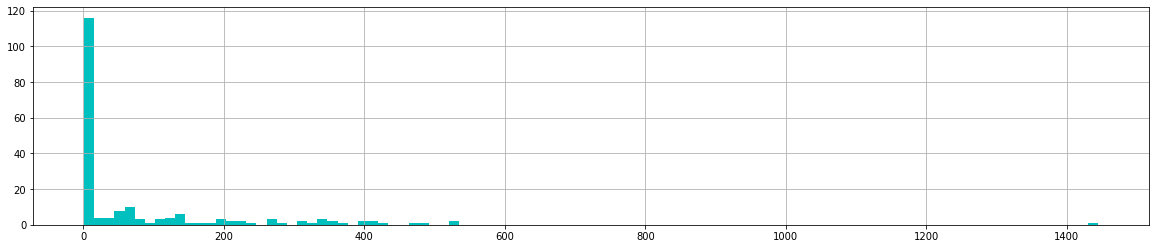

In [343]:
plt.figure(figsize = (20,4))
ratings['no_of_ratings'].hist(bins=100,color='c')

<AxesSubplot:>

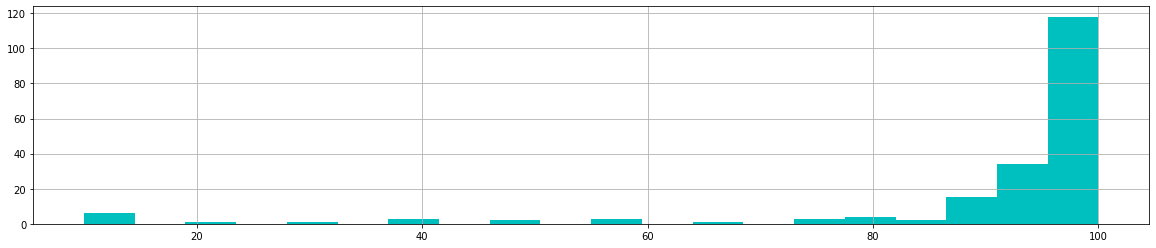

In [344]:
plt.figure(figsize = (20,4))
ratings['rating_avg'].hist(bins=20,color='c')

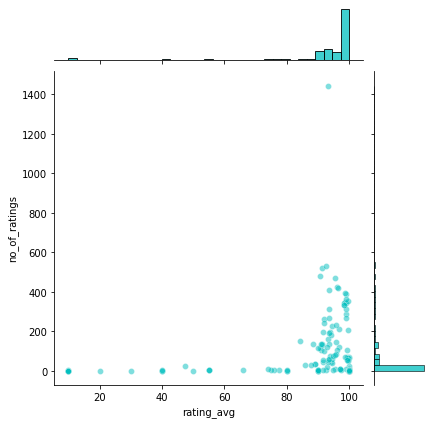

In [345]:
sns.jointplot(x='rating_avg', y='no_of_ratings', data= ratings, alpha = 0.5, color='c')

<div class="alert alert-warning">
분석에서 아래와 같이 rating이 몇개 이상인 책만 뽑아서 봐도 되는것...?
</div>

In [346]:
ratings['no_of_ratings'].describe()

count     193.000000
mean       79.528497
std       157.730190
min         1.000000
25%         1.000000
50%         4.000000
75%        86.000000
max      1445.000000
Name: no_of_ratings, dtype: float64

하위 50%의 분포를 살펴보면: 1~4정도임

In [347]:
ratings['no_of_ratings'].quantile(np.arange(0, 0.5, 0.05))

0.00    1.0
0.05    1.0
0.10    1.0
0.15    1.0
0.20    1.0
0.25    1.0
0.30    1.0
0.35    2.0
0.40    2.0
0.45    2.0
Name: no_of_ratings, dtype: float64

그렇다면 평가를 n개 이하 했던 inactive user 에 대해서도?

In [348]:
count_user_rating = all_review.pivot_table(index='title', columns = 'nickname', values = 'rating').iloc[:,2:].apply(lambda col : np.sum(~np.isnan(col)))

# return_best_n(count,10).index 를 구하면 제목만 뽑을 수 있음
return_best_n(count_user_rating,10)

,statistic
nickname,
마임,65
대룡리말바위,54
고트프리트,52
swagger,51
kwonjkim,47
코끼리311,46
initialj,46
미다진구,46
던힐발란스,45


In [354]:
count_user_rating = pd.DataFrame(count_user_rating)
count_user_rating.columns = ['user_rating_cnt']

In [357]:
count_user_rating['user_rating_cnt'].describe()

count    4448.000000
mean        3.490333
std         6.102040
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        65.000000
Name: user_rating_cnt, dtype: float64

In [356]:
count_user_rating['user_rating_cnt'].quantile(np.arange(0, 0.5, 0.05))

0.00    1.0
0.05    1.0
0.10    1.0
0.15    1.0
0.20    1.0
0.25    1.0
0.30    1.0
0.35    1.0
0.40    1.0
0.45    1.0
Name: user_rating_cnt, dtype: float64

(array([3.934e+03, 2.360e+02, 1.460e+02, 5.700e+01, 2.700e+01, 2.100e+01,
        1.900e+01, 6.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1. ,  7.4, 13.8, 20.2, 26.6, 33. , 39.4, 45.8, 52.2, 58.6, 65. ]),
 <BarContainer object of 10 artists>)

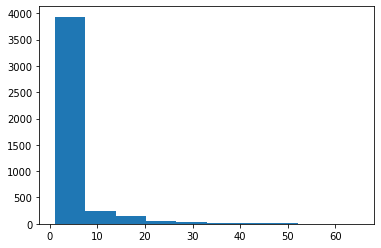

In [358]:
plt.hist(count_user_rating)

{'whiskers': [<matplotlib.lines.Line2D at 0x2be3a174948>,
 'caps': [<matplotlib.lines.Line2D at 0x2be3cc69e88>,
 'boxes': [<matplotlib.lines.Line2D at 0x2be3cc695c8>],
 'medians': [<matplotlib.lines.Line2D at 0x2be3cc79d08>],
 'fliers': [<matplotlib.lines.Line2D at 0x2be3cc79cc8>],
 'means': []}

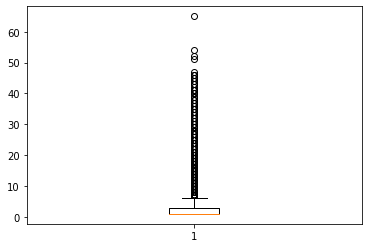

In [361]:
plt.boxplot(data = count_user_rating, x='user_rating_cnt')

In [21]:
ratings_min_6 = ratings.query('no_of_ratings >= 6')
ratings_min_6.head(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
[강연형] 제국대학의 조센징,95.441767,498,0.945783
[공포괴담집] 무조건 모르는 척하세요,93.908629,197,0.949239
[공포괴담집] 저승에서 돌아온 남자,94.405286,227,0.964758


<div class="alert alert-warning">
근본적으로 우리가 책이 200권 정도밖에 없는데, <br>
리뷰 5개 이상인 책으로 바꾸면 그게 반토막 나게됨<br>
그렇게 데이터 수를 희생하면서 봐도 되는 것인지..?<br>
</div>

# 3. Prediction With Surprise<a class="anchor" id="bullet3"></a>

In [176]:
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
from surprise import SVD
from surprise import NMF
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise.model_selection import cross_validate

In [177]:
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
9969,ljhljh,100,안재욱이 읽는 유항림의 마권,안재욱,유항림,재욱이형님 목소리를 이렇게 듣게되네요 ^^\r\n너무 행복합니다,2018.12.20,커뮤니케이션북스,오디오북스,celeb


In [178]:
all_review['rating'].unique()

array([100,  60,  80,  90,  70,  20,  30,  10,  40,  50], dtype=int64)

In [179]:
all_review['new_rating'] = all_review['rating'].apply(lambda x : x/10)
all_review['new_rating'].unique()

array([10.,  6.,  8.,  9.,  7.,  2.,  3.,  1.,  4.,  5.])

In [180]:
all_review.sample()

,nickname,rating,title,voice,author,review,created,publish,genre,read_by,new_rating
3778,spp,80,[윤덕원 낭독] 해피 아포칼립스! _ 작은책,윤덕원,백민석,목소리 좋아요,2019.07.05,아르테,소설문학,celeb,8.0


In [181]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(all_review[['nickname', 'title', 'new_rating']], reader)

In [456]:
for algo in [SVD(), NMF(), KNNBasic(), KNNBaseline()]:
    cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0437  1.0048  1.0761  1.0133  1.0116  1.0299  0.0267  
MAE (testset)     0.6036  0.5808  0.6103  0.5737  0.5872  0.5911  0.0138  
Fit time          2.19    2.05    3.03    1.91    2.14    2.26    0.40    
Test time         0.09    0.05    0.13    0.05    0.11    0.08    0.03    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.0313  3.1503  3.2178  3.1443  3.1365  3.1360  0.0599  
MAE (testset)     2.7475  2.8646  2.9327  2.8662  2.8539  2.8530  0.0596  
Fit time          3.87    3.15    3.65    2.88    3.40    3.39    0.35    
Test time         0.10    0.10    0.04    0.07    0.03    0.07    0.03    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matr

<div class="alert alert-warning">
이건 cosine similarity로 kNN 구하기<br>
안해도됨
</div>

In [ ]:
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBasic(sim_options=sim_options)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [183]:
calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
pod_SVD = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
pod_SVD

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.047612,0.605319,1.642606,0.143283
KNNBasic,1.090485,0.560712,0.990017,2.791874
NMF,3.120457,2.825224,2.614339,0.071487


<div class="alert alert-warning">
이건 우리만의 알고리즘 만들떄 필요한거<br>
안해도됨
</div>

In [393]:
# from __future__ import (absolute_import, division, print_function,
#                         unicode_literals)
# import numpy as np
# from six import iteritems
# import heapq

# from surprise.prediction_algorithms.predictions import PredictionImpossible
# from surprise.prediction_algorithms.algo_base import AlgoBase

In [316]:
# kf = KFold(n_splits=3)

# algo = NMF() #이걸 SVD, KNNBasic으로 바꿔가며 결과 비교

# for trainset, testset in kf.split(data):
#     # train and test algorithm.
#     algo.fit(trainset)
#     predictions = algo.test(testset)

#     # Compute and print Root Mean Squared Error
#     accuracy.rmse(predictions, verbose=True)

RMSE: 76.8622
RMSE: 76.8241
RMSE: 76.8932


In [395]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [185]:
mydramalist = pd.read_csv('C:/Users/Hanna Kim/Desktop/drama_recommendation/reviews_to_top_40.csv', index_col = 0)

In [187]:
mydramalist.sample()

,title,reviewer,overall,story,acting,music,rewatch
11493,Page Turner,purplenette,6.0,5.0,7.0,10.0,1.0


In [188]:
reader = Reader(rating_scale=(1, 10))

data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'overall']], reader)

In [464]:
from surprise import accuracy

In [189]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'overall']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_overall = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_overall

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.443960,1.043970,3.305328,0.140624
KNNBasic,1.667899,1.150982,0.273602,1.787231
NMF,2.567722,2.253064,4.469056,0.241675


In [190]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'story']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_story = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_story

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.499974,1.084920,2.927170,0.244683
KNNBasic,1.689910,1.176318,0.319478,1.805504
NMF,2.573527,2.244179,5.427482,0.241686


In [191]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'music']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_music = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_music

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.523111,1.114940,3.230026,0.172205
KNNBasic,1.816377,1.282025,0.356715,2.045194
NMF,2.560522,2.208450,7.153865,0.172209


In [192]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'acting']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_acting = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_acting

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.260538,0.884254,3.702428,0.355718
KNNBasic,1.417649,0.961363,0.328785,1.594746
NMF,2.795942,2.533747,5.541843,0.196143


In [193]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'rewatch']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_rewatch = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_rewatch

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,2.163973,1.616850,4.622301,0.479717
KNNBasic,2.537376,1.821015,0.812491,2.657557


In [194]:
mydramalist[mydramalist.isna().any(axis=1)]

,title,reviewer,overall,story,acting,music,rewatch


In [195]:
mydramalist['mean'] = (mydramalist.iloc[:, 2:]).apply(np.mean, axis=1)

In [196]:
mydramalist.sample()

,title,reviewer,overall,story,acting,music,rewatch,mean
11458,Ghost,purplenette,8.0,8.0,9.0,8.0,6.0,7.8


In [197]:
mydramalist['mean'] = (mydramalist.iloc[:, 2:]).apply(np.mean, axis=1)
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'mean']], reader)

calc = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    calc.append(tmp)
    
mdl_mean = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_mean

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.362060,1.000769,2.817463,0.176194
KNNBasic,1.572859,1.124550,0.343728,1.587420


직관적으로는 팟빵 평점 데이터가 별로일 것 같은데, `

Text(0.5, 1.0, 'MyDramaList Ratings')

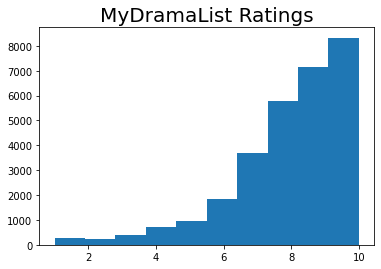

In [33]:
plt.hist(mydramalist['overall'], bins = 10)
plt.title("MyDramaList Ratings", fontsize = 20)

Text(0.5, 1.0, 'Podbbang Ratings')

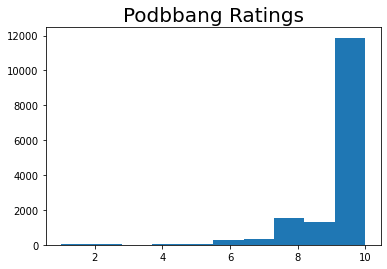

In [31]:
plt.hist(all_review['new_rating'], bins = 10)
plt.title("Podbbang Ratings", fontsize = 20)

# 난 너무 화가 난다

이럴거면 그냥 다 10점 주는 알고리즘 만들자

In [174]:
from surprise import AlgoBase
from surprise import Dataset
from surprise.model_selection import cross_validate


class all_10(AlgoBase):

    def __init__(self):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)

    def estimate(self, u, i):

        return 10

all_10으로 팟빵 예측한 결과는

In [198]:
calc = []
# Perform cross validation
algorithm = all_10()
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
calc.append(tmp)
    
pod_all_10 = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
pod_all_10

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
all_10,2.735595,2.098703,0.003991,0.085447


근데 그래도 pod_SVD가 예측 더 잘함...why

팟빵 데이터에도 10점이 아닌게 있으니 다 10점을 때려버리면 안될듯 <br>
그러면 전체 데이터의 평균(global mean)을 사용해서 예측한다면?

In [175]:
class GlobalMean(AlgoBase):

    def __init__(self):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)

    def fit(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)

        # Compute the average rating. We might as well use the
        # trainset.global_mean attribute ;)
        self.the_mean = np.mean([r for (_, _, r) in
                                 self.trainset.all_ratings()])

        return self

    def estimate(self, u, i):

        return self.the_mean

In [182]:
data = Dataset.load_from_df(all_review[['nickname', 'title', 'new_rating']], reader)


calc = []
# Perform cross validation
algorithm = GlobalMean()
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
calc.append(tmp)
    
pod_global_mean = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
pod_global_mean

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
GlobalMean,1.18641,0.786285,0.012964,0.04355


In [201]:
mydramalist.sample()

,title,reviewer,overall,story,acting,music,rewatch,mean
9974,Drama Special Series Season 1: White Christmas,maymaymaymay,10.0,10.0,9.0,10.0,7.0,9.2


In [215]:
data = Dataset.load_from_df(mydramalist[['reviewer', 'title', 'overall']], reader)


calc = []
# Perform cross validation
algorithm = GlobalMean()
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
calc.append(tmp)
    
mdl_global_mean = pd.DataFrame(calc).set_index('Algorithm').sort_values('test_rmse') 
mdl_global_mean

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
GlobalMean,1.830709,1.400354,0.017295,0.075132


In [203]:
a = pd.DataFrame(np.array([mdl_acting.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_acting_SVD'])

b = pd.DataFrame(np.array([mdl_story.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_story_SVD'])

c = pd.DataFrame(np.array([mdl_mean.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_mean_SVD'])

d = pd.DataFrame(np.array([pod_SVD.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['pod_SVD'])

e = pd.DataFrame(np.array([pod_all_10.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['pod_all_10'])

f = pd.DataFrame(np.array([pod_global_mean.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['pod_global_mean'])

g = pd.DataFrame(np.array([mdl_global_mean.iloc[0, :]]), columns = mdl_acting.iloc[0, :].index, index = ['mdl_global_mean'])

In [206]:
all_algo = pd.concat([a,b,c,d,e,f,g], axis = 0)
all_algo

,test_rmse,test_mae,fit_time,test_time
mdl_acting_SVD,1.260538,0.884254,3.702428,0.355718
mdl_story_SVD,1.499974,1.084920,2.927170,0.244683
mdl_mean_SVD,1.362060,1.000769,2.817463,0.176194
pod_SVD,1.047612,0.605319,1.642606,0.143283
pod_all_10,2.735595,2.098703,0.003991,0.085447
pod_global_mean,1.186410,0.786285,0.012964,0.043550
mdl_global_mean,1.830818,1.400521,0.018617,0.101727


In [210]:
all_algo.loc[['mdl_global_mean', 'mdl_acting_SVD']]

,test_rmse,test_mae,fit_time,test_time
mdl_global_mean,1.830818,1.400521,0.018617,0.101727
mdl_acting_SVD,1.260538,0.884254,3.702428,0.355718


In [212]:
all_algo.loc[['pod_global_mean', 'pod_SVD']]

,test_rmse,test_mae,fit_time,test_time
pod_global_mean,1.186410,0.786285,0.012964,0.043550
pod_SVD,1.047612,0.605319,1.642606,0.143283


mdl과 다르게 pod은 바보같아 보이는 global_mean을 적용하나 똑똑한 SVD를 적용하나 error의 차이가 크지 않아요.<br>
애초에 데이터가 10점에 몰려있으니 그게 그거겟죠? <br>
**그러면 우리는 팟빵의 오디오북 퀄리티가 높아서 이런 결과가 나왔다고 할 수 있을까?**<br>
### 놉

In [220]:
all_algo.iloc[6,0] - all_algo.iloc[6,0]

1.8308176341614588

In [221]:
all_algo

,test_rmse,test_mae,fit_time,test_time
mdl_acting_SVD,1.260538,0.884254,3.702428,0.355718
mdl_story_SVD,1.499974,1.084920,2.927170,0.244683
mdl_mean_SVD,1.362060,1.000769,2.817463,0.176194
pod_SVD,1.047612,0.605319,1.642606,0.143283
pod_all_10,2.735595,2.098703,0.003991,0.085447
pod_global_mean,1.186410,0.786285,0.012964,0.043550
mdl_global_mean,1.830818,1.400521,0.018617,0.101727


In [42]:
all_review

,nickname,rating,title,voice,author,review,created,publish,genre,read_by
0,유노창민,100,저스트 어 모멘트,이나리,이경화,잘들었습니다.,2020.11.06,탐,소설문학,someone
1,나이스가이72,100,[단편] 헤엄치는 밤,최인영,한유주,내용 목소리 넘 좋습니다.,2020.10.29,미디어창비,소설문학,someone
2,하브,100,[단편] 헤엄치는 밤,최인영,한유주,완전 내용도 장난 아니게 좋네요!! 그리고 목소리도 너무 좋아 집중해서 잘 들을 수...,2020.10.29,미디어창비,소설문학,someone
3,양수,100,[단편] 헤엄치는 밤,최인영,한유주,빠져드는 목소리입니다^^,2020.10.29,미디어창비,소설문학,someone
4,티씨지는부산더락,100,[단편] 헤엄치는 밤,최인영,한유주,목소리 너무 좋아요,2020.10.28,미디어창비,소설문학,someone
...,...,...,...,...,...,...,...,...,...,...
15526,kay333,100,명작동화 영한대역 I,"박미경,손선희",그림 형제,"유명한 그림 형제 동화를 한국어ᆞ영어로 동시에 듣고, 색다른 정보도 알게 되네요. ^^",2019.07.05,왓북,어린이동화,someone
15527,자연에서,100,명작동화 영한대역 I,"박미경,손선희",그림 형제,아이 잠자리에서 영한대역으로 틀어주면 좋을거 같아요. 영어 난이도가 쉽진 않지만 자...,2019.07.01,왓북,어린이동화,someone
15528,후후후크,90,[단편] 햇볕 동동 구리 동동,NaN,윤기현,애들 재울때 들으려고 샀는데\r\n아빠가 더 재밌네요 옛날 생각도 나고,2020.01.19,창비,어린이동화,robot
15531,소민맘,100,마법사 똥맨,NaN,송언,재밌어요,2019.12.19,창비,어린이동화,robot


In [45]:
pivot_review = all_review.pivot_table(index= 'nickname', columns = 'title', values = 'rating')

In [55]:
#sparsity
print(f"데이터 sparsity : {1 - (pivot_review.count().sum() / (pivot_review.shape[0]*pivot_review.shape[1]))}")

데이터 sparsity : 0.9821065975223279


In [58]:
rate = all_review[['nickname', 'title', 'rating']]
rate['rating'] /= 10
rate.sample(3)

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,nickname,title,rating
13484,213626,어른이 되면 괜찮을 줄 알았다,10.0
14024,sooozy,[EBS 세계문학전집] 걸리버 여행기,10.0
10736,꾸우레복검,나는 왠지 대박날 것만 같아!,10.0


In [60]:
user_df = pd.DataFrame(list(rate.nickname	.unique()), columns = ['nickname'])
user_df['usr_id'] = random.sample(range(1,len(user_df)+1), len(user_df))

title_df = pd.DataFrame(list(rate.title.unique()), columns = ['title'])
title_df['ttl_id'] = random.sample(range(1,len(title_df)+1), len(title_df))

rate = rate.merge(user_df, how = 'left' )
rate = rate.merge(title_df, how = 'left' )
rate.columns = ['user', 'title', 'rating', 'usr_id', 'ttl_id']
rate.sample()

,user,title,rating,usr_id,ttl_id
3586,이궁우궁,[이승열 낭독] 모든 곳에 존재하는 로마니의 황제 퀴에크 _ 작은책,8.0,81,108


In [82]:
rate

,user,title,rating,usr_id,ttl_id
0,유노창민,저스트 어 모멘트,10.0,300,15
1,나이스가이72,[단편] 헤엄치는 밤,10.0,3753,50
2,하브,[단편] 헤엄치는 밤,10.0,545,50
3,양수,[단편] 헤엄치는 밤,10.0,2419,50
4,티씨지는부산더락,[단편] 헤엄치는 밤,10.0,1072,50
...,...,...,...,...,...
15523,kay333,명작동화 영한대역 I,10.0,988,72
15524,자연에서,명작동화 영한대역 I,10.0,3134,72
15525,후후후크,[단편] 햇볕 동동 구리 동동,9.0,2553,149
15526,소민맘,마법사 똥맨,10.0,1869,101


In [270]:
review_var_count[review_var_count['rating_count']>=10]

count    1646.000000
mean        7.729648
std         8.491895
min         2.000000
25%         2.000000
50%         4.000000
75%        10.000000
max        65.000000
Name: rating_count, dtype: float64